In [1]:
import keras
import os
import pandas as pd
from keras.utils import np_utils

import SimpleITK as sitk
import os
import numpy as np 
import scipy.ndimage
import matplotlib.pyplot as plt
from numpy.random import rand
from skimage import measure, morphology
import cv2
from scipy.ndimage import zoom
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Define paths
base_path = os.path.abspath("./") # Your root directory
dataset_path = os.path.join(base_path, "dataset") # Your dataset folder

In [3]:
dt = pd.read_csv(os.path.join(dataset_path, '8ba42c65-534a-4cdf-b983-e7fcaaaa3002_TrainingSet_metaData.csv'))
dt.head()

,Filename,md_Disability,md_Relapse,md_SymptomsOfTB,md_Comorbidity,md_Bacillary,md_DrugResistance,md_HigherEducation,md_ExPrisoner,md_Alcoholic,md_Smoking,md_Severity,SVR_Severity,CTR_LeftLungAffected,CTR_RightLungAffected,CTR_LungCapacityDecrease,CTR_Calcification,CTR_Pleurisy,CTR_Caverns
0,CTR_TRN_001.nii.gz,0,0,0,1,0,0,0,0,1,1,4,LOW,1,0,0,0,0,0
1,CTR_TRN_002.nii.gz,0,0,0,1,1,3,0,0,0,1,4,LOW,0,1,0,0,0,0
2,CTR_TRN_003.nii.gz,0,0,1,1,0,0,0,0,0,0,5,LOW,1,1,0,1,0,0
3,CTR_TRN_004.nii.gz,0,0,0,0,1,2,0,0,0,1,4,LOW,1,0,0,0,0,0
4,CTR_TRN_005.nii.gz,0,0,0,1,1,2,0,1,0,1,3,HIGH,1,0,0,0,0,0


In [4]:
# Raw data path
INPUT_FOLDER = 'TrainingSet_1_of_2/'  
training_data_raw = os.path.join(dataset_path, INPUT_FOLDER)

# Check inside target folder
print(os.listdir(dataset_path))
print(training_data_raw)

patients = sorted(os.listdir(training_data_raw))
print(patients[:10])

['TestSet_Masks', '8ba42c65-534a-4cdf-b983-e7fcaaaa3002_TrainingSet_metaData.csv', '5aa39c27-0c20-4330-b28e-9af8a5369033_TestSet_metaData.csv', '975bbbb8-62f9-4d79-a165-50dfad603f7b_README.txt', 'TestSet', 'TrainingSet_1_of_2', 'TrainingSet_2_of_2', 'y_train_clef.npy', 'TrainingSet_Masks']
/home/hasib/uniformizing-3D/dataset/TrainingSet_1_of_2/
['CTR_TRN_001.nii.gz', 'CTR_TRN_002.nii.gz', 'CTR_TRN_003.nii.gz', 'CTR_TRN_004.nii.gz', 'CTR_TRN_005.nii.gz', 'CTR_TRN_006.nii.gz', 'CTR_TRN_007.nii.gz', 'CTR_TRN_008.nii.gz', 'CTR_TRN_009.nii.gz', 'CTR_TRN_010.nii.gz']


In [5]:
# Resize 2D slices
w, h = 128, 128
def rs_img(img):
    '''W and H is 128 now
    '''
    img = np.transpose(img)
    flatten = [cv2.resize(img[:,:,i], (w, h), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img


# Subset slice selection (SSS)
def change_depth_sss(img):
    
    factor = 16
    img_start = img[:,:,:factor]
    
    mid = int(img.shape[-1]/2)
    img_middle = img[:,:,mid-factor:mid+factor]
    
    img_end = img[:,:,-factor:]
    img = np.concatenate((img_start, img_middle, img_end), axis=2)
    return img


# Even slice selection (ESS)
def change_depth_ess(img):
    
    '''ESS depth size is 32 as min depth size is 47, so we cannot evenly select 64 slices!'''

    # Ignore volumes which have depth less than 64
    target_depth = 64

    #print(img.shape) 

    scan_depth = int(img.shape[-1])
    
    # If depth is not 64, make it 64
    if scan_depth < 64:
        number = 64 - scan_depth
        #print(number)
        # take last image and stack
        extend = [img[:,:,-1] for _ in range(number)]
        extend = np.array(np.dstack(extend))
        #print(extend.shape)
        img = np.concatenate((img, extend), axis=2)
    
    else:
        factor = int(np.floor(scan_depth / target_depth)) # min depth is 32
        #print(factor) # floor and ceil result in different values
        #print(scan_depth, factor)

        flatten = []
        idx = 0

        for i in range(0, scan_depth, factor):
          #print(idx)

            if idx>=scan_depth:
                break
            else:
                flatten.append(img[:,:,i])

        img = np.array(np.dstack(flatten))

    # hardcode from bottom, if not 64 slices
    img = img[:,:,:target_depth]     

    #print("Final shape: ", img.shape)
    
    # hardcode from bottom, if not 32 slices
    img = img[:,:,:target_depth]

    assert img.shape[-1] == target_depth , "Error"
    return img


# Spline interpolated zoom (SIZ)
def change_depth_siz(img):
    desired_depth = 64
    current_depth = img.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (1, 1, depth_factor), mode='nearest')
    return img_new


def normalize(image):
    
    MIN_BOUND = -1000 # anything below this we are not interested in 
    MAX_BOUND = 700   # anything above too

    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


def zero_center(image):
    image = image - PIXEL_MEAN
    return image


def plot_seq(data, name):
    
    a, b = 3, 20
    data = np.reshape(data, (a, b, 128, 128))
    test_data = data
    r, c = test_data.shape[0], test_data.shape[1]

    cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

    heights = [a[0].shape[0] for a in test_data]
    widths = [a.shape[1] for a in test_data[0]]

    fig_width = 10.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
          gridspec_kw={'height_ratios':heights})

    for i in range(r):
        for j in range(c):
            axarr[i, j].imshow(test_data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.savefig('{}/{}.png'.format(log_path, name), dpi=1000)
    plt.show()


# NOT USING THIS NOW
def resize_depth_wise(img3d):
    '''
      Inputs a 3d tensor with uneven depth
      Outputs a 3d tensor with even depth, in this case depth=64
    '''
  
  # patient image 3D
    p = img3d
  # list of 3D slices of p
    p_2d = []

    depth = 2

    n = 0
    c = 0

    for c in range(70):
        img = img3d[:,:,n+depth]
        p_2d.append(img)
        n = n+depth
        c = c+1
        
    p_3d_d64 = np.array(np.dstack(p_2d))
    return p_3d_d64


In [6]:
training_data_raw

'/home/hasib/uniformizing-3D/dataset/TrainingSet_1_of_2/'

In [7]:
# Classes for data loading and preprocessing
class ImageCLEFDataset:
    def __init__(
            self, 
            datadir, 
            csv_path,
    ):
        
        # Patient names
        self.ids = sorted(os.listdir(datadir))
        # Sorted patient names
        self.images_fps = [os.path.join(datadir, image_id) for image_id in self.ids]
        
        
        # Read csv
        csv = pd.read_csv(os.path.join(dataset_path, csv_path))
        
        # Get labels
        svr_scores = csv['SVR_Severity'].values
        svr_score_binary = []
        for s in svr_scores:
            if s == "LOW":
                svr_score_binary.append(0)
            if s == "HIGH":
                svr_score_binary.append(1)
        
        svr_score_binary = np.array(svr_score_binary)
        
        num_classes = 2
        # Onehot labels
        self.labels = np_utils.to_categorical(svr_score_binary, num_classes)
        
        
        
    def __getitem__(self, i):
        # Read data
        img = sitk.ReadImage(self.images_fps[i])

        # Get array
        img = sitk.GetArrayFromImage(img)

        # Resize x,y,z
        img = rs_img(img)

        # What downsampling technique?
        img = change_depth_sss(img)
        
        gt = self.labels[i]
        
        return img, gt
        
    def __len__(self):
        return len(self.ids)

In [8]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


In [9]:
# image path, csv path
dataset = ImageCLEFDataset(training_data_raw, '8ba42c65-534a-4cdf-b983-e7fcaaaa3002_TrainingSet_metaData.csv')

In [10]:
image, gt = dataset[55] 
image.shape, gt.shape

((128, 128, 64), (2,))

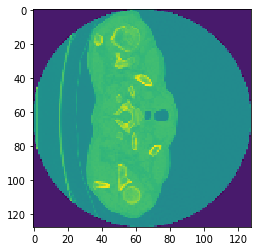

In [11]:
plt.imshow(image[:,:,55])

In [12]:
train_dataloader = Dataloder(dataset, batch_size=2, shuffle=True)

In [13]:
# Test train loader
x , y = next(iter(train_dataloader))
print(x.shape, y.shape)

(2, 128, 128, 64) (2, 2)


In [14]:
#https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet#Section-3:-Preprocessing-our-Data

In [15]:
for batch_idx, (features, targets) in enumerate(train_dataloader):
    print(batch_idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
